In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, InputLayer
from tensorflow.keras.callbacks import ModelCheckpoint

In [14]:
# carrega o dataset
df = pd.read_csv("dataset.csv")
df.index = pd.to_datetime(df["id"], errors="ignore")

C:\Users\lucas\AppData\Local\Temp\ipykernel_34164\1432928690.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  df.index = pd.to_datetime(df["id"], errors="ignore")


In [15]:
# inserção das colunas que vão para o treinamento
cols = [
    "humid",
    "ws100",
    "wdisp100",
    "vertdisp100",
]
df_for_training = df[cols].astype(float)

In [16]:
# oor enquanto estou usando o StardardScaler msm
scaler = StandardScaler()
df_for_training_scaled = scaler.fit_transform(df_for_training)

In [17]:
# aqui defino a quantidade de dados para realizar a previsão
sequence_length = 36
X, y = [], []

for i in range(len(df_for_training_scaled) - sequence_length):
    X.append(df_for_training_scaled[i : i + sequence_length])
    y.append(df_for_training_scaled[i + sequence_length])

X = np.array(X)
y = np.array(y)

print(f"Formato de X: {X.shape}")
print(f"Formato de y: {y.shape}")

Formato de X: (7525, 36, 4)
Formato de y: (7525, 4)


In [18]:
# divião de dados de treinamento e teste. 80% treinamento, 20% para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [19]:
# definição do modelo
model1 = Sequential(
    [
        InputLayer(shape=(sequence_length, len(cols))),
        LSTM(128),
        Dense(len(cols), activation="linear"),
    ]
)

model1.compile(optimizer="adam", loss="mse")
cp1 = ModelCheckpoint("model1.keras", save_best_only=True)

In [20]:
# treinamento
model1.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=15, callbacks=[cp1]
)

# faz a previsão baseado no modelo criado
y_pred = model1.predict(X_test)

Epoch 1/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 0.2837 - val_loss: 0.1850
Epoch 2/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.1633 - val_loss: 0.1742
Epoch 3/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - loss: 0.1547 - val_loss: 0.1628
Epoch 4/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.1474 - val_loss: 0.1587
Epoch 5/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.1508 - val_loss: 0.1570
Epoch 6/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.1462 - val_loss: 0.1568
Epoch 7/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 49ms/step - loss: 0.1501 - val_loss: 0.1560
Epoch 8/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.1419 - val_loss: 0.1579
Epoch 9/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 0.1394 - val_loss: 0.1620
Epoch 10/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - loss: 0.1414 - val_loss: 0.1553
Epoch 11/15
189/189 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.1408 - val_loss: 0.1563
Epoch 12/15
189/189 ━━━━━━━━━━━━━━━━━━━━

In [21]:
# renormalização dos dados
y_pred_orig = scaler.inverse_transform(y_pred)
y_test_orig = scaler.inverse_transform(y_test)

'humid': RMSE = 1.2828, NRMSE = 0.0338, Erro Relativo = 1.22%


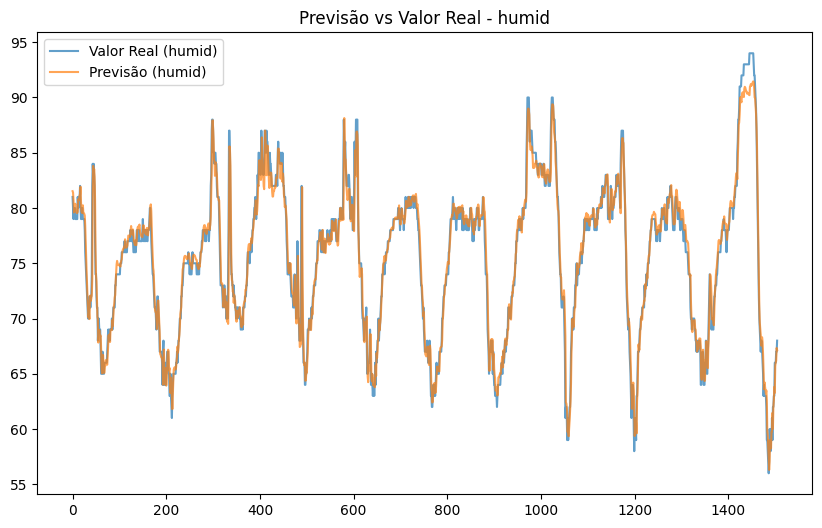

'ws100': RMSE = 0.6061, NRMSE = 0.0623, Erro Relativo = 6.08%


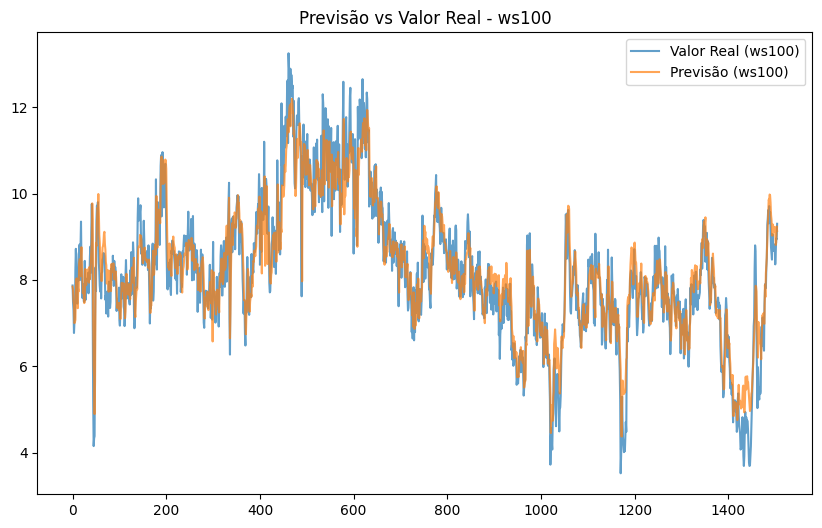

'wdisp100': RMSE = 0.1634, NRMSE = 0.0782, Erro Relativo = 16.19%


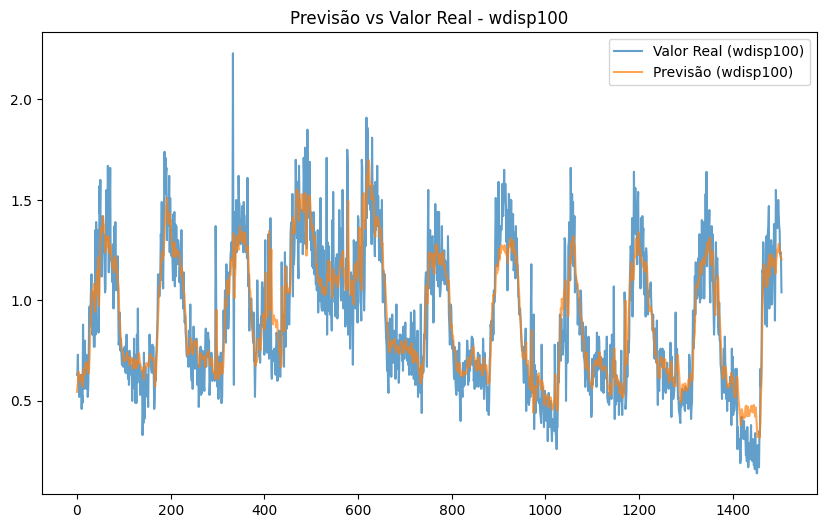

'vertdisp100': RMSE = 0.1479, NRMSE = 0.0663, Erro Relativo = 17.06%


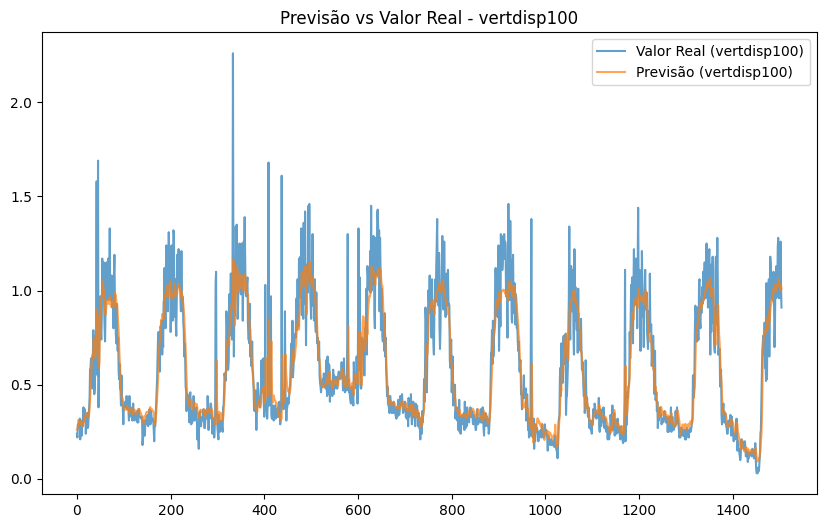

In [22]:
# verificações: RMSE, NRMSE, erro relativo e disposição dos gráficos
for i, col in enumerate(cols):
    # RMSE e NRMSE
    rmse = np.sqrt(np.mean((y_test_orig[:, i] - y_pred_orig[:, i]) ** 2))
    nrmse = rmse / (y_test_orig[:, i].max() - y_test_orig[:, i].min())

    # erro relativo médio
    erro_relativo = (
        np.mean(np.abs((y_test_orig[:, i] - y_pred_orig[:, i]) / y_test_orig[:, i]))
        * 100
    )

    print(
        f"'{col}': RMSE = {rmse:.4f}, NRMSE = {nrmse:.4f}, Erro Relativo = {erro_relativo:.2f}%"
    )

    plt.figure(figsize=(10, 6))
    plt.plot(y_test_orig[:, i], label=f"Valor Real ({col})", alpha=0.7)
    plt.plot(y_pred_orig[:, i], label=f"Previsão ({col})", alpha=0.7)
    plt.legend()
    plt.title(f"Previsão vs Valor Real - {col}")
    plt.show()

In [23]:
# análise de correlação entre variáveis e 'ws100'
correlations = df_for_training.corr(method="pearson")
print("\nCorrelação de cada variável com 'ws100':")
print(correlations["ws100"])


Correlação de cada variável com 'ws100':
humid         -0.433935
ws100          1.000000
wdisp100       0.558741
vertdisp100    0.365820
Name: ws100, dtype: float64
